In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
import warnings
from scipy.interpolate import CubicSpline

In [2]:
warnings.filterwarnings("ignore")

In [3]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Ano')
        plt.ylabel('Valor')
        plt.title(column)
        plt.xticks(rotation=45)

    plt.show()

In [4]:
def centered_moving_average(column, window_action, window_size):
    start_index, end_index = window_action
    data = column.to_numpy()

    data_length = len(data)

    for i in range(start_index, end_index + 1):
        if not np.isnan(data[i]):
            init = data[i]
            start = max(0, i - window_size)
            end = min(data_length, i + window_size + 1)
            window = data[start:end]
            valid_values = [value for value in window if not pd.isna(value)]
            if len(valid_values) > 0:
                data[i] = np.mean(valid_values)

    modified_column = pd.Series(data, name=column.name)

    return modified_column

In [5]:
# Polynomial Interpolation data inputation method
def four_ends_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        for i in range(4):
            column = first_filler(column, i, len(column) - 1 - i)
            column = last_filler(column, i, len(column) - 1 - i)
    return column

def four_ends_linear_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        size = len(column) - 1
        column = first_filler(column, 0, size)
        column = last_filler(column, 0, size)
        for i in range(0, 4):
            value = column.at[i]
            if i > 0 and (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_first = prev_valid_index(column, i)
                end_first = next_valid_index(column, i)
                gap = list(range(start_first + 1, end_first))
                linear_a = (column.at[end_first] - column.at[start_first])/(end_first - start_first)
                linear_b = column.at[start_first] - linear_a*start_first
                column.at[i] = linear_a*i + linear_b
            value = column.at[size - 4 + i]
            if i > 0 and (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_last = prev_valid_index(column, size - 4 + i)
                end_last = next_valid_index(column, size - 4 + i)
                gap = list(range(start_last + 1, end_last))
                linear_a = (column.at[end_last] - column.at[start_last])/(end_last - start_last)
                linear_b = column.at[start_last] - linear_a*start_last
                column.at[size - 4 + i] = linear_a*i + linear_b
    return column

def first_filler(column, init, end):
    if pd.isnull(column.at[init]) or np.isnan(column.at[init]):
        first_valid_index = 0
        while first_valid_index <= end and (pd.isnull(column.at[first_valid_index]) or 
                                             np.isnan(column.at[first_valid_index])):
            first_valid_index += 1
        if first_valid_index > end:
            column.at[init] = 0.0
        else:
            column.at[init] = column.at[first_valid_index]
    return column
    
def last_filler(column, init, end):
    if pd.isnull(column.at[end]) or np.isnan(column.at[end]):
        last_valid_index = len(column) -1
        while last_valid_index >= init and (pd.isnull(column.at[last_valid_index]) or 
                                         np.isnan(column.at[last_valid_index])):
            last_valid_index -= 1
        if last_valid_index < init:
            column.at[end] = 0.0
        else:
            column.at[end] = column.at[last_valid_index]
    return column
  
def neareast_four_indexes(column, start, end):
    return prev_four_valid_indexes(column, start) + next_four_valid_indexes(column, end)

def prev_four_valid_indexes(column, pos):
    prev_index = pos
    index_prev_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_prev_list[3 - i] = prev_index
            prev_index -= 1
            while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
                prev_index -= 1
    return index_prev_list  

def next_four_valid_indexes(column, pos):
    next_index = pos
    index_next_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_next_list[i] = next_index
            next_index += 1
            while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
                next_index += 1
    return index_next_list  

def prev_valid_index(column, pos):
    prev_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        prev_index -= 1
        while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
            prev_index -= 1
    return prev_index  

def next_valid_index(column, pos):
    next_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        next_index += 1
        while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
            next_index += 1
    return next_index

def interpolating_polynomial(nearest_indexes, nearest_values):
    coeffs = np.polyfit(nearest_indexes, nearest_values, 3)
    return np.poly1d(coeffs)

def polynomial_filler(column):
    size = len(column) -1
    if column.isnull().any() and column.isna().any():
        for i, value in enumerate(column):
            if (i > 3 and i < size - 3) and (pd.isnull(value) or np.isnan(value) or (value == '')):
                nearest_values = []
                start = prev_valid_index(column, i)
                end = next_valid_index(column, i)
                gap = list(range(start + 1, end))
                nearest_indexes = neareast_four_indexes(column, start, end)
                for index in nearest_indexes:
                    nearest_values.append(column.at[index])
                polynomial = interpolating_polynomial(nearest_indexes, nearest_values)
                for x in gap:
                    column.at[x] = polynomial(x)
                plot_polynomial(polynomial, nearest_indexes[0], nearest_indexes[len(nearest_indexes) - 1], 50, gap, nearest_indexes, column.name)
    return column

def plot_polynomial(polynomial, start, end, precision, interpolated_list, nearest_indexes, column_name):
    x = np.linspace(start, end, precision)
    y = polynomial(x)

    plt.figure()

    plt.plot(x, y)

    interpolated_x = interpolated_list  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='red')
    interpolated_x = nearest_indexes  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='green')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(column_name)

    plt.show()
    
def replace_negative_with_float_zeros(x):
    return 0.0 if x < 0 else x

In [34]:
def read_csv_replace_missing_by_polynomial(file_path):
    with open(file_path, 'r') as f:
        
        df = pd.read_csv(file_path, skiprows=1)
        df = df.iloc[:, 2:-1]
        
        i = 0
        for col in df.columns: # Elimina missing values por médias e transforma em float
            if i > 2:
                df[col] = df[col].replace('-9999', np.nan)
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].replace('', np.nan).astype(float)
                df[col] = four_ends_filler(df[col])
                df[col] = polynomial_filler(df[col]) 
            i += 1
        return df

In [46]:
df = read_csv_replace_missing_by_polynomial('idh.csv')
df = df.T
header = df.iloc[0]
df = df[1:]
df.columns = header
df

Estado,Acre,Alagoas,Amazonas,Amapá,Bahia,Ceará,Distrito Federal,Espírito Santo,Goiás,Maranhão,...,Paraná,Rio de Janeiro,Rio Grande do Norte,Rondônia,Roraima,Rio Grande do Sul,Santa Catarina,Sergipe,São Paulo,Tocantins
1980,0.506,0.41,0.608,0.582,0.515,0.44,0.751,0.673,0.66,0.405,...,0.7,0.733,0.444,0.595,0.679,0.744,0.734,0.477,0.728,0.465
1991,0.584,0.474,0.658,0.687,0.53,0.517,0.806,0.704,0.722,0.456,...,0.76,0.782,0.539,0.635,0.728,0.786,0.785,0.539,0.787,0.56
2012,0.701,0.651,0.691,0.707,0.678,0.701,0.825,0.758,0.744,0.648,...,0.772,0.762,0.695,0.694,0.738,0.763,0.792,0.684,0.812,0.71
2013,0.706,0.648,0.702,0.734,0.68,0.705,0.837,0.765,0.752,0.661,...,0.782,0.768,0.71,0.687,0.738,0.773,0.801,0.683,0.818,0.719
2014,0.715,0.666,0.706,0.725,0.694,0.71,0.836,0.772,0.757,0.663,...,0.788,0.78,0.723,0.692,0.744,0.779,0.807,0.696,0.825,0.737
2015,0.718,0.666,0.711,0.728,0.701,0.715,0.837,0.776,0.755,0.669,...,0.786,0.785,0.733,0.706,0.748,0.787,0.809,0.697,0.823,0.73
2016,0.723,0.68,0.711,0.733,0.705,0.722,0.847,0.779,0.764,0.68,...,0.797,0.789,0.732,0.715,0.752,0.789,0.814,0.697,0.835,0.734
2017,0.712,0.679,0.728,0.732,0.71,0.73,0.842,0.78,0.765,0.685,...,0.797,0.791,0.728,0.721,0.746,0.793,0.817,0.699,0.831,0.74
2018,0.733,0.689,0.718,0.741,0.71,0.739,0.845,0.788,0.771,0.686,...,0.805,0.805,0.739,0.73,0.76,0.797,0.819,0.71,0.837,0.749
2019,0.739,0.687,0.726,0.737,0.718,0.744,0.859,0.793,0.774,0.694,...,0.807,0.809,0.742,0.73,0.749,0.801,0.826,0.705,0.845,0.751


In [47]:
df['Ano'] = df.index
df = df.reset_index(drop=True)
print(df['Ano'])
missing_years = list(range(1981, 1991)) + list(range(1992, 2013)) + list(range(2022, 2023))

for year in missing_years: 
    novo_ano = pd.Series({'Ano': year})
    df = df.append(novo_ano, ignore_index=True)
    
df['Ano'] = df['Ano'].astype(int)    
df = df.sort_values('Ano', ascending=True)
df = df.set_index('Ano')
df.to_csv('idh_para_interpolacao.csv', index=True)
df

0     1980
1     1991
2     2012
3     2013
4     2014
5     2015
6     2016
7     2017
8     2018
9     2019
10    2020
11    2021
Name: Ano, dtype: object


,Acre,Alagoas,Amazonas,Amapá,Bahia,Ceará,Distrito Federal,Espírito Santo,Goiás,Maranhão,...,Paraná,Rio de Janeiro,Rio Grande do Norte,Rondônia,Roraima,Rio Grande do Sul,Santa Catarina,Sergipe,São Paulo,Tocantins
Ano,,,,,,,,,,,,,,,,,,,,,
1980,0.506,0.41,0.608,0.582,0.515,0.44,0.751,0.673,0.66,0.405,...,0.7,0.733,0.444,0.595,0.679,0.744,0.734,0.477,0.728,0.465
1981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
def read_csv_replace_missing_by_polynomial_2(file_path):
    with open(file_path, 'r') as f:
        
        df = pd.read_csv(file_path)
        
        i = 0
        for col in df.columns: # Elimina missing values por médias e transforma em float
            if i > 0:
                df[col] = df[col].replace('-9999', np.nan)
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].replace('', np.nan).astype(float)
                df[col] = four_ends_linear_filler(df[col])
                df[col] = centered_moving_average(df[col], (0, len(df[col]) - 1), 24) #2 anos
                df[col] = polynomial_filler(df[col]) 
            i += 1
        return df

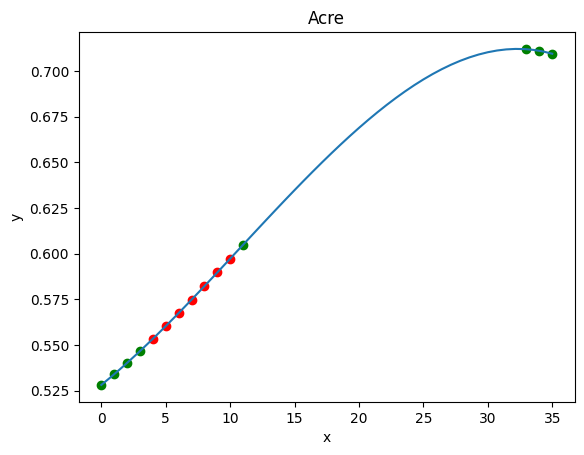

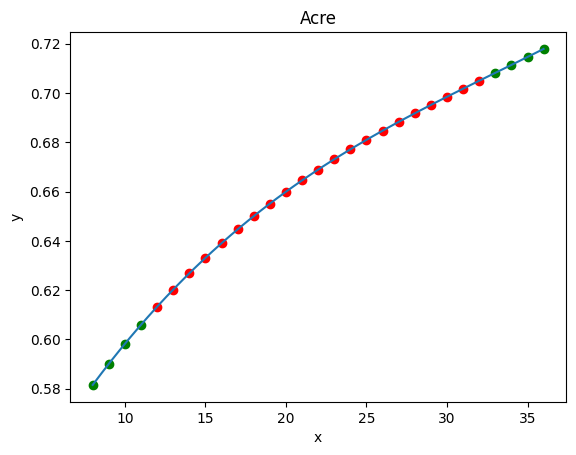

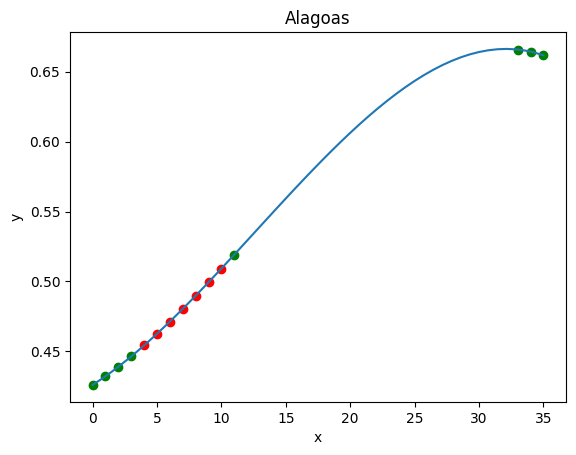

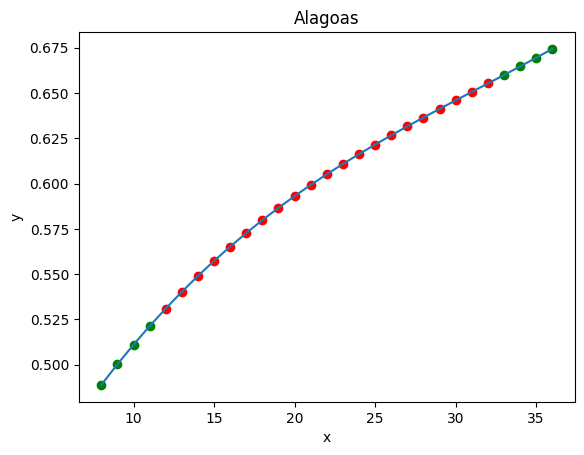

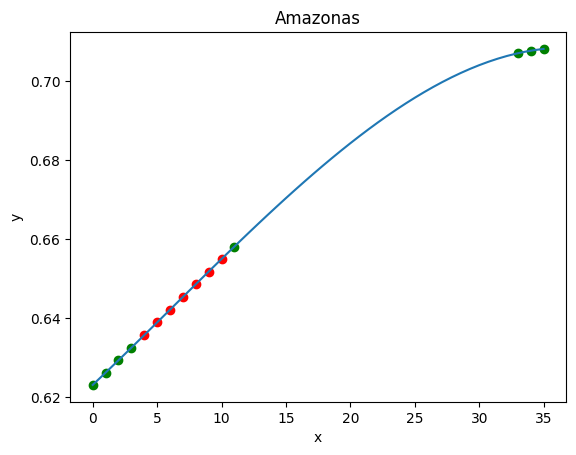

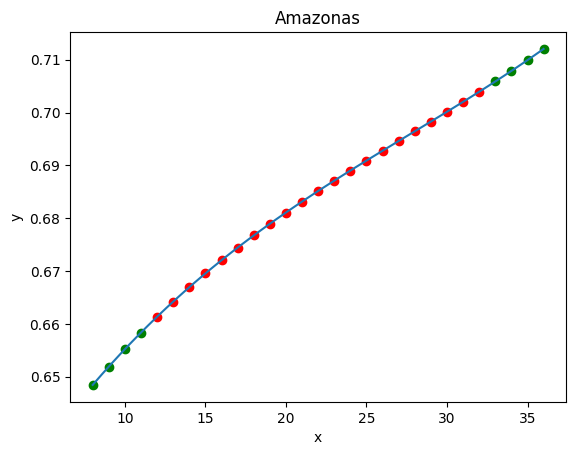

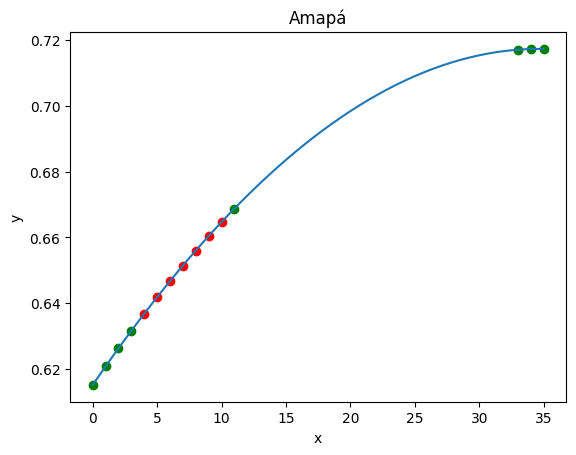

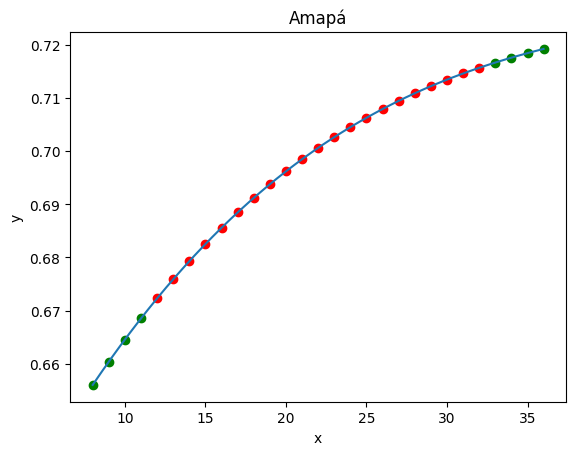

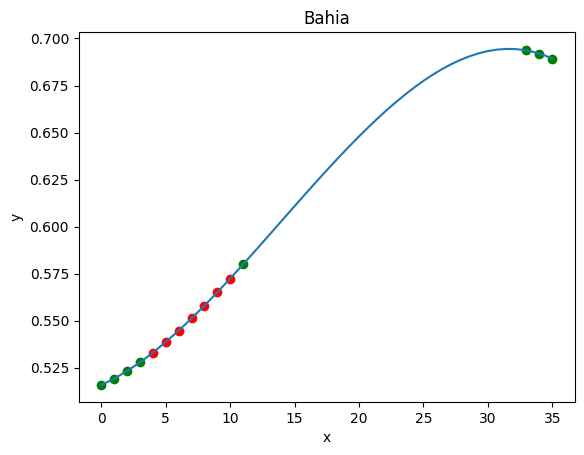

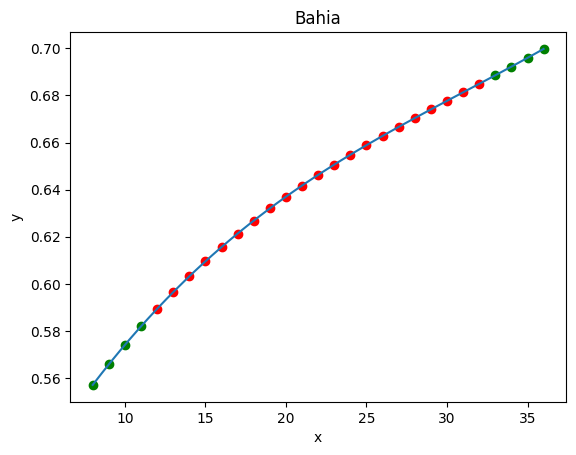

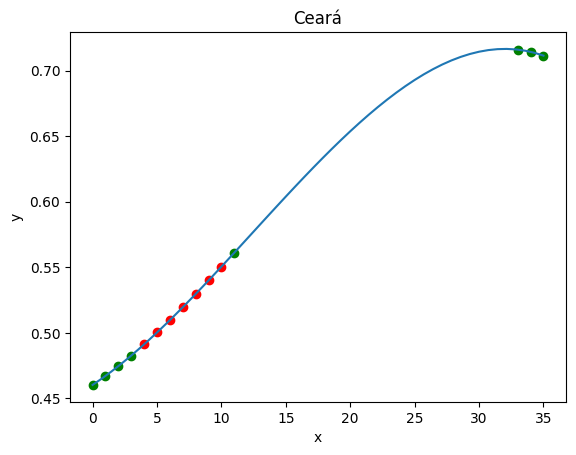

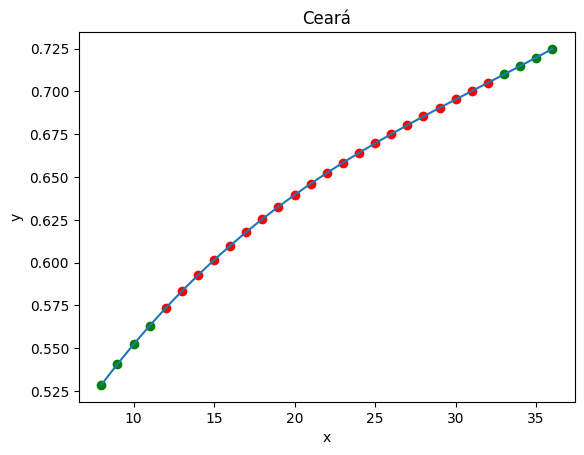

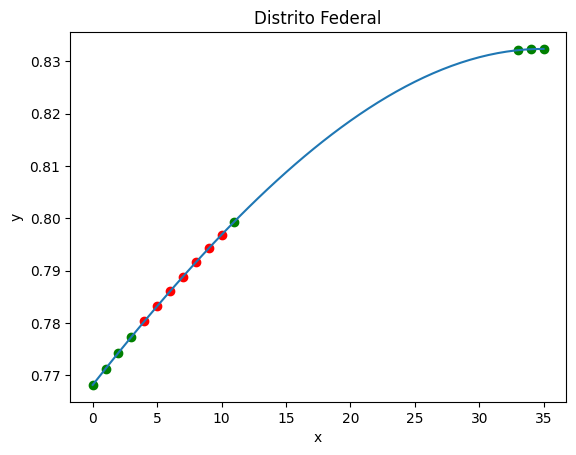

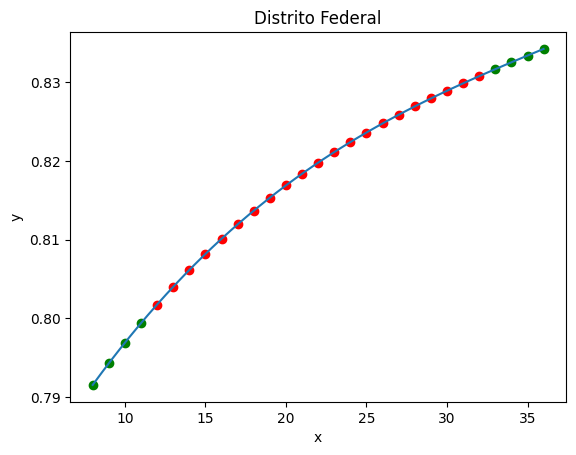

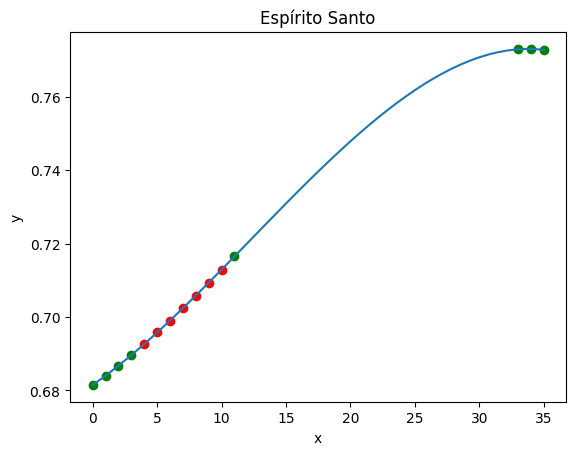

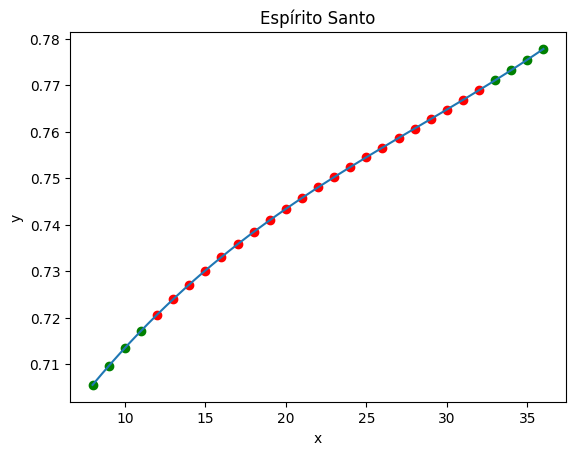

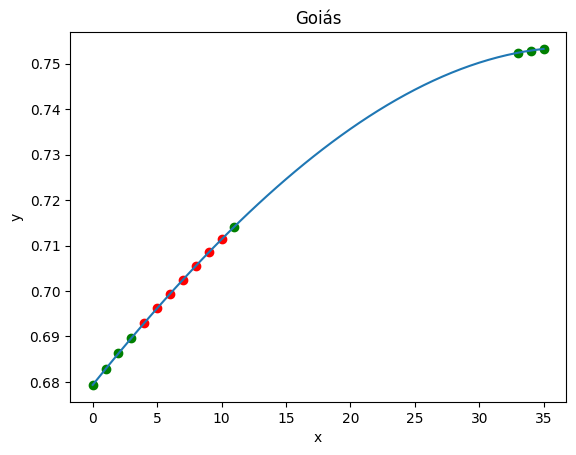

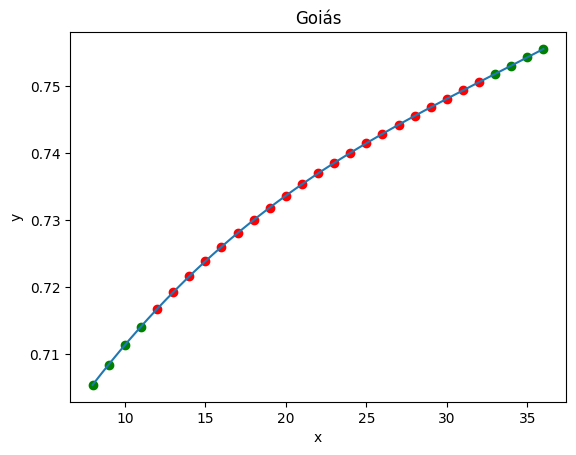

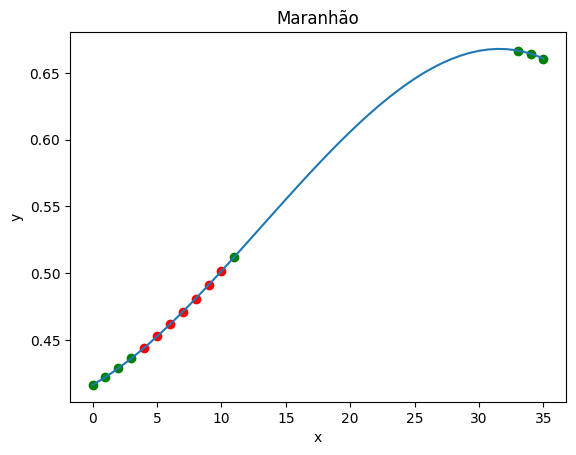

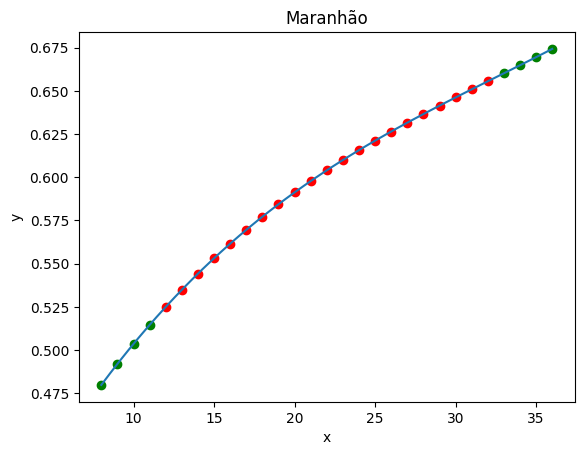

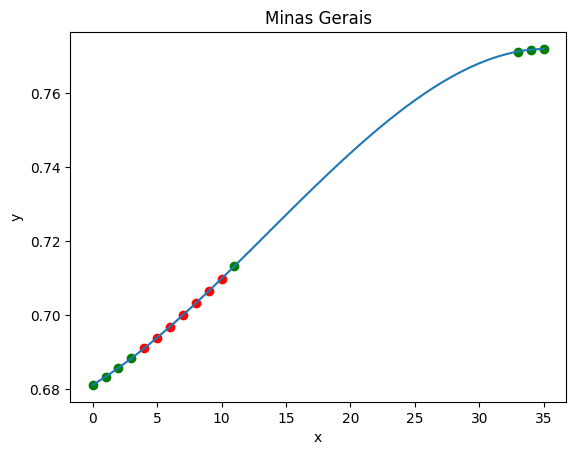

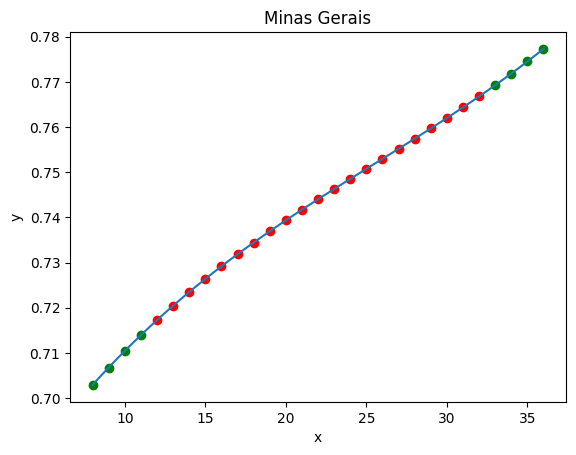

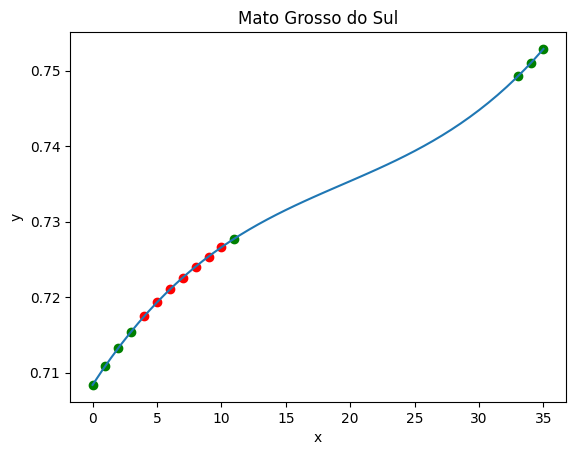

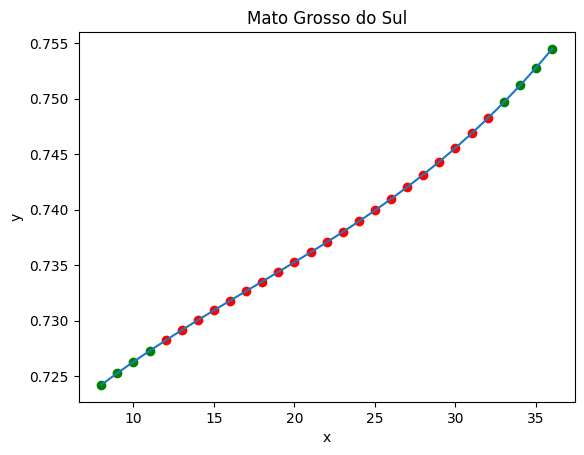

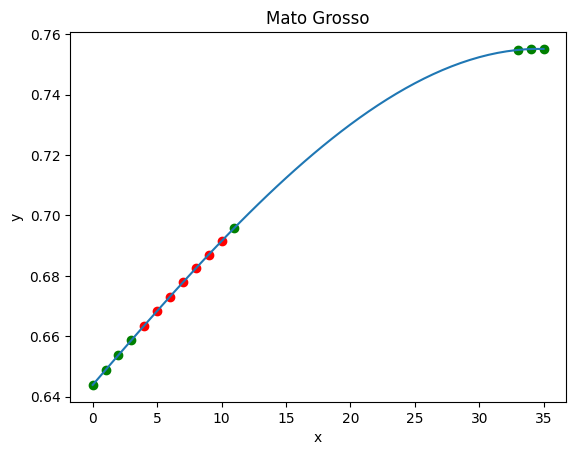

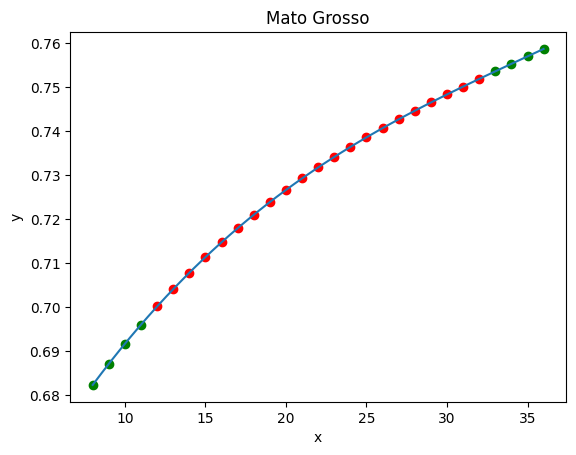

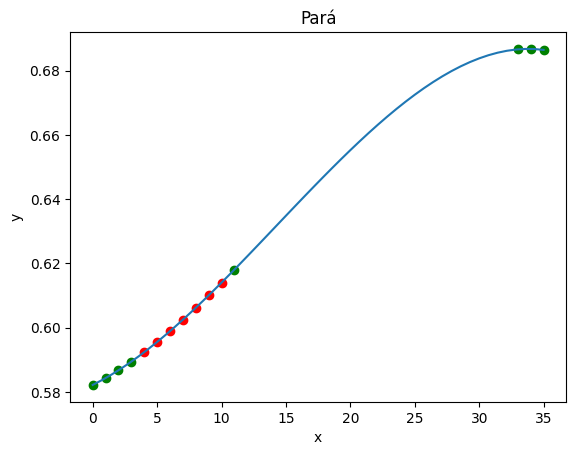

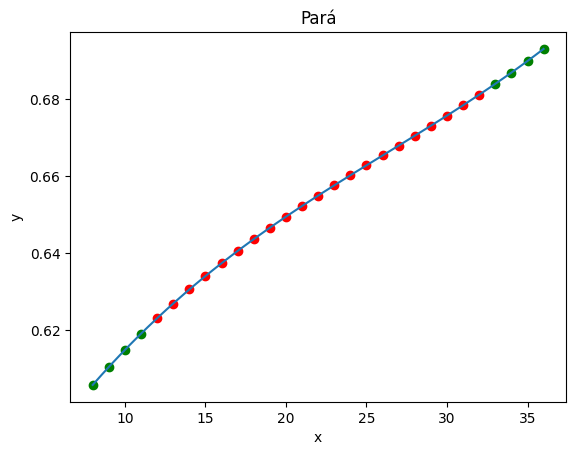

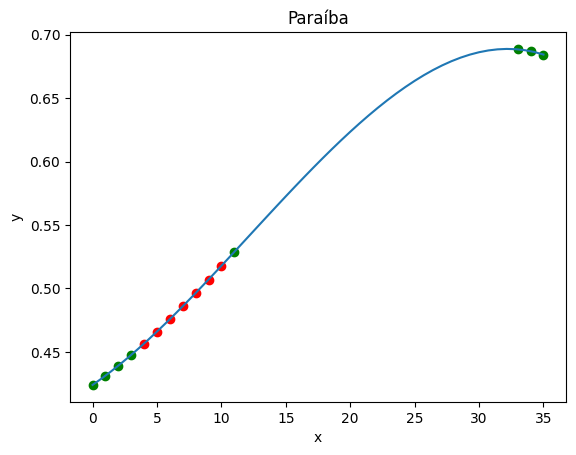

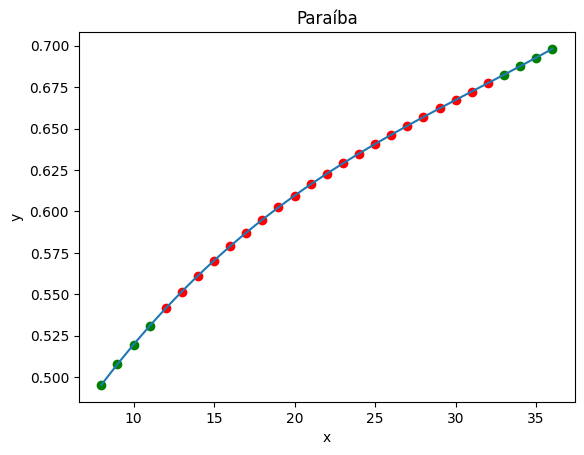

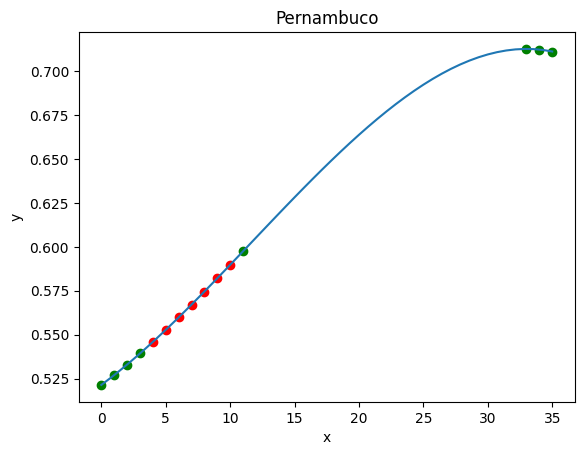

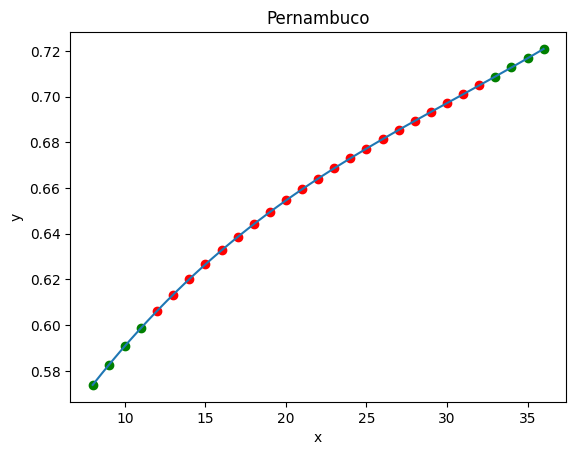

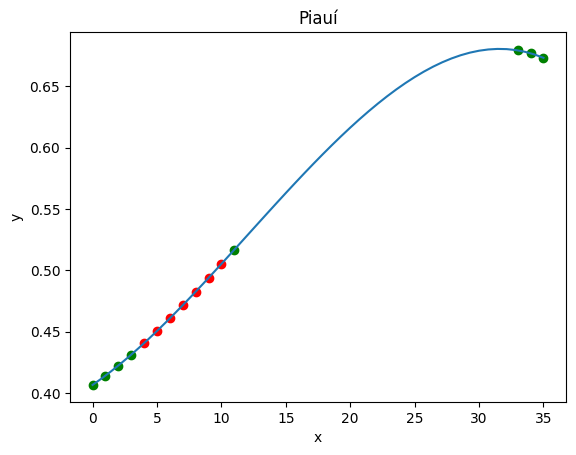

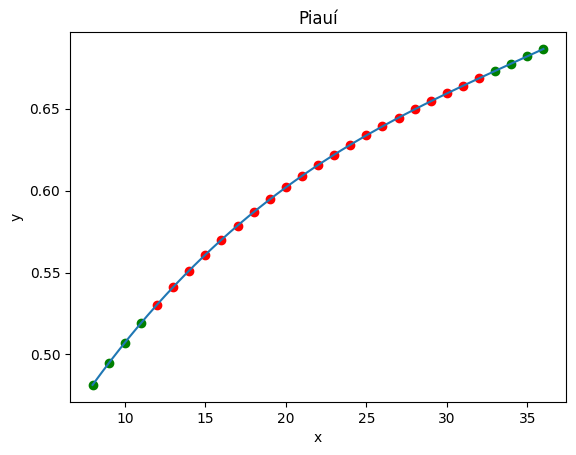

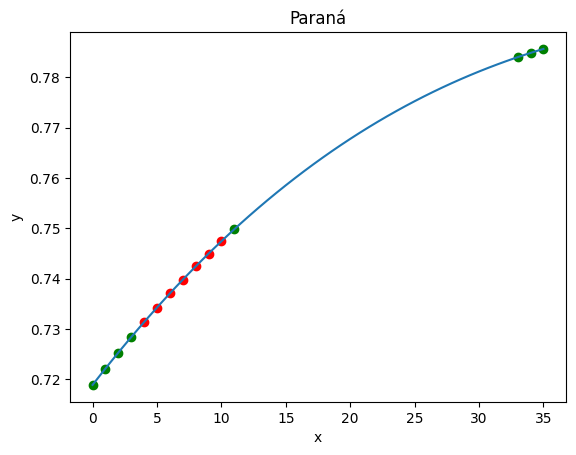

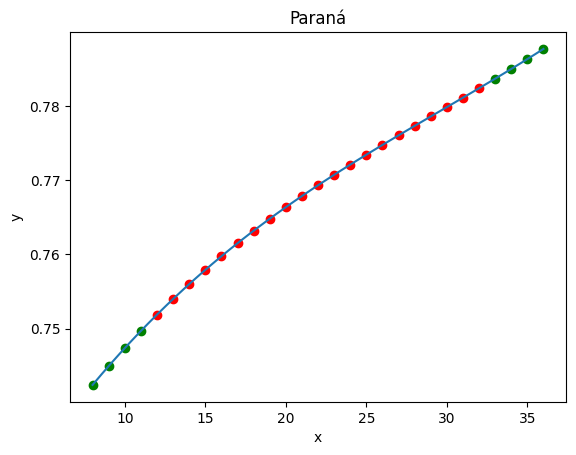

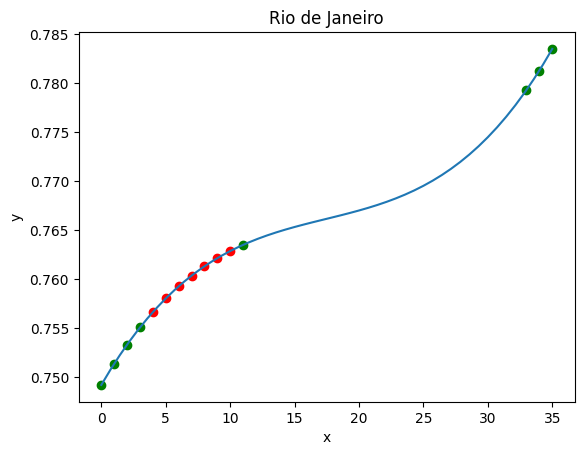

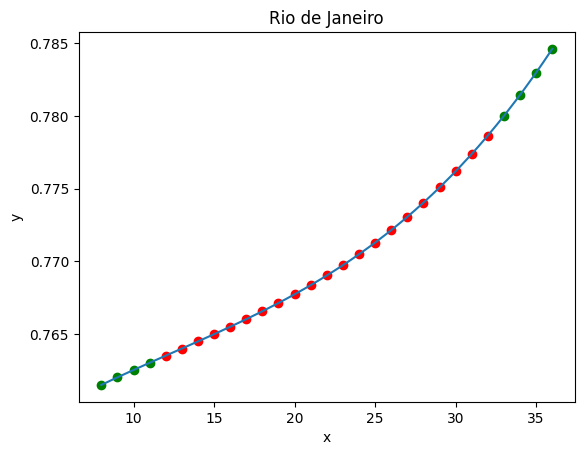

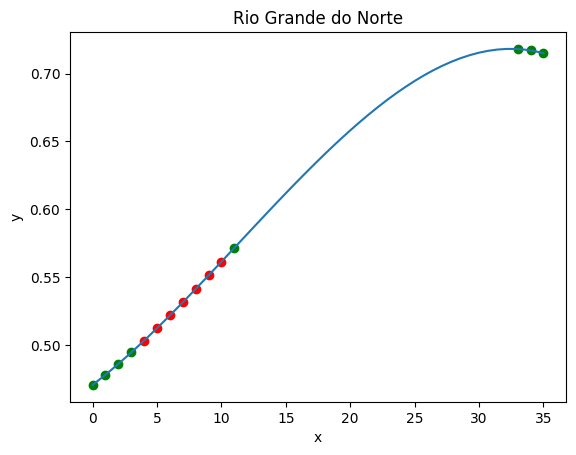

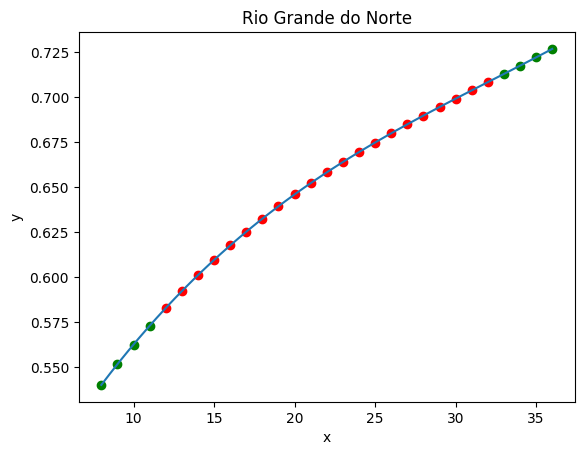

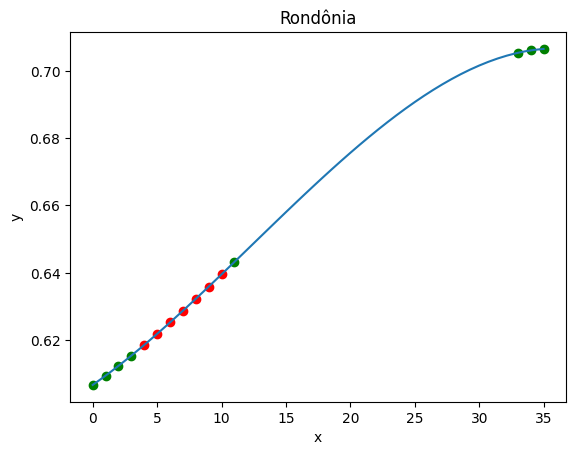

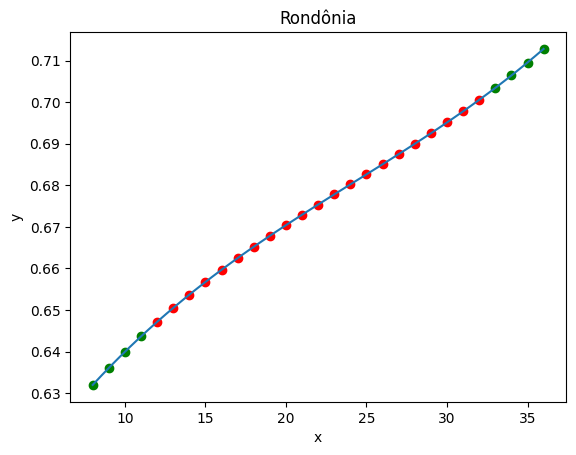

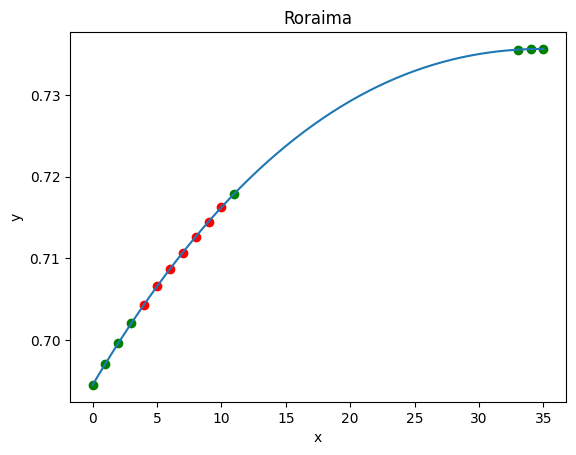

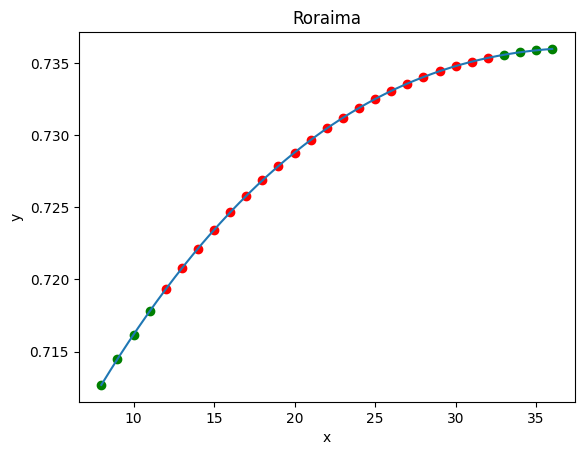

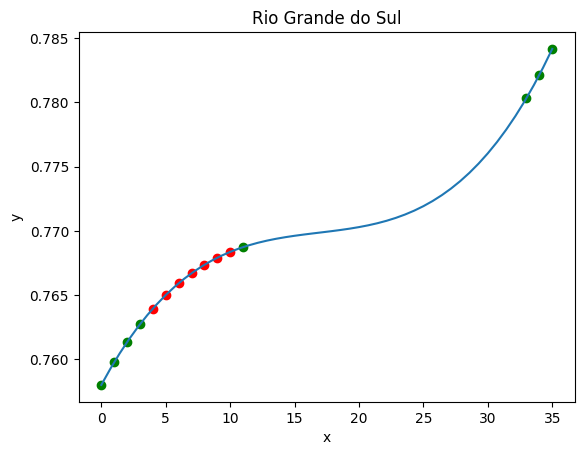

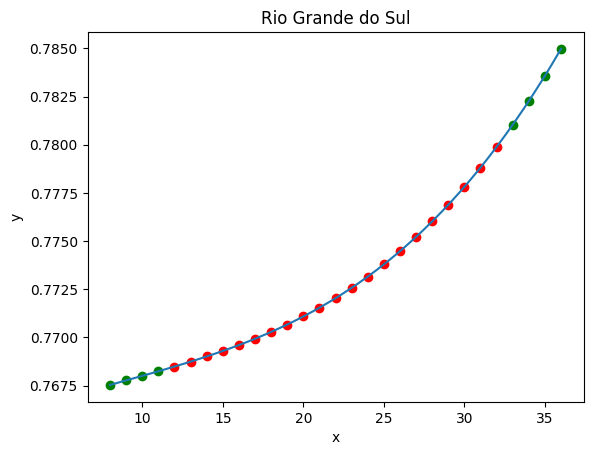

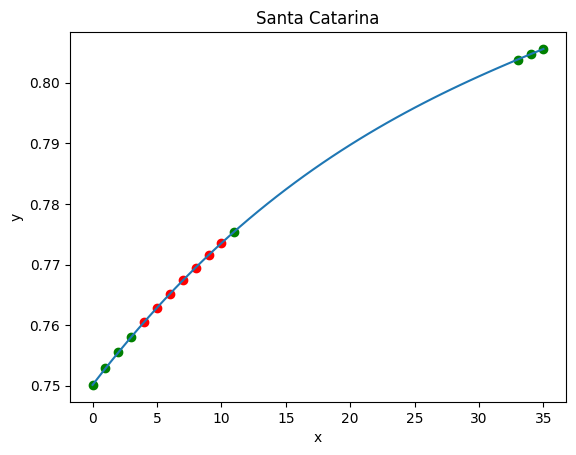

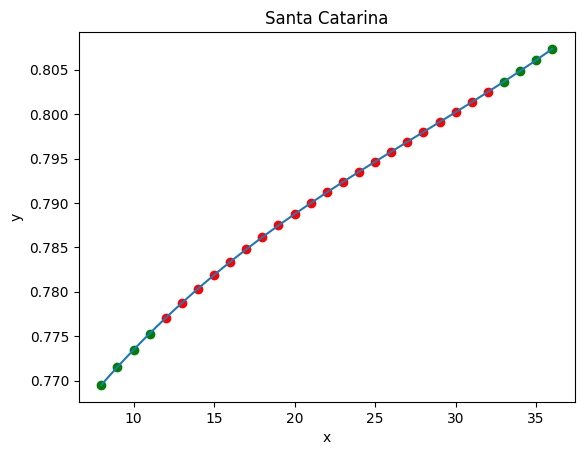

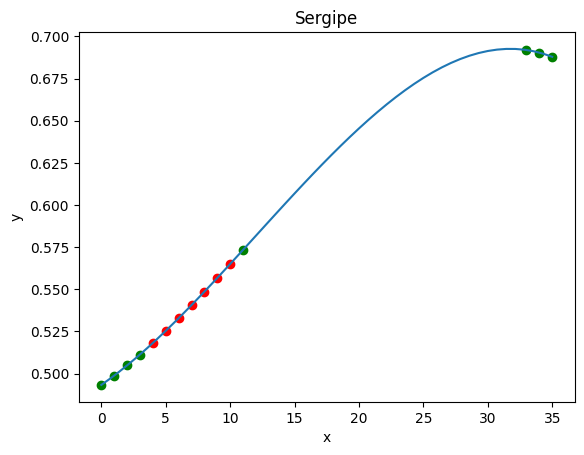

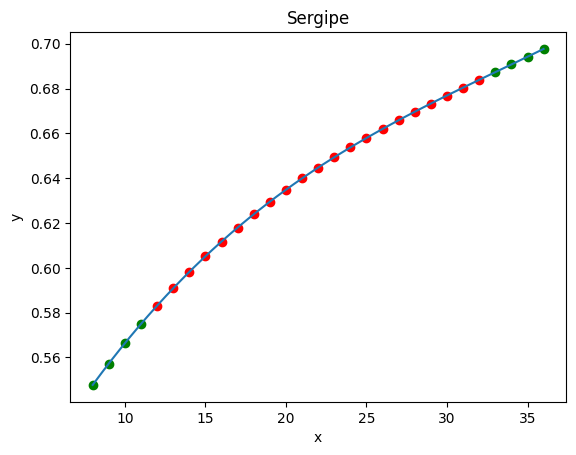

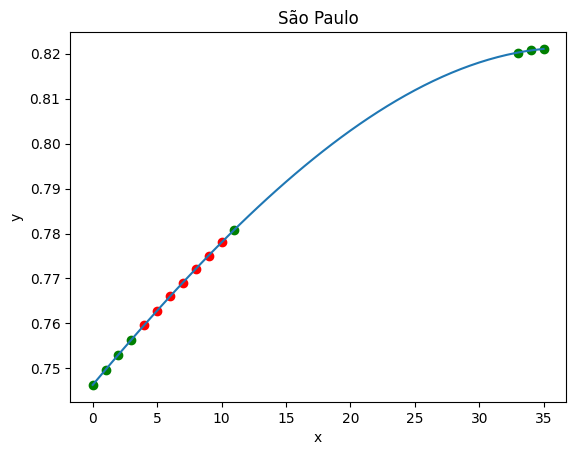

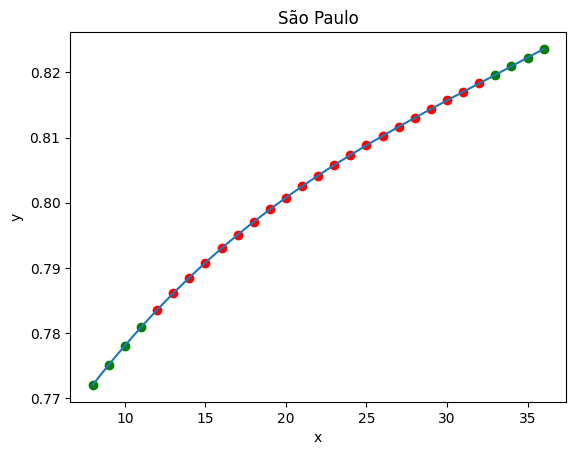

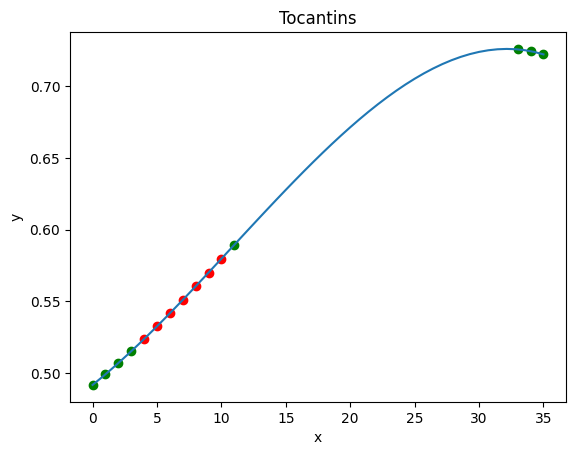

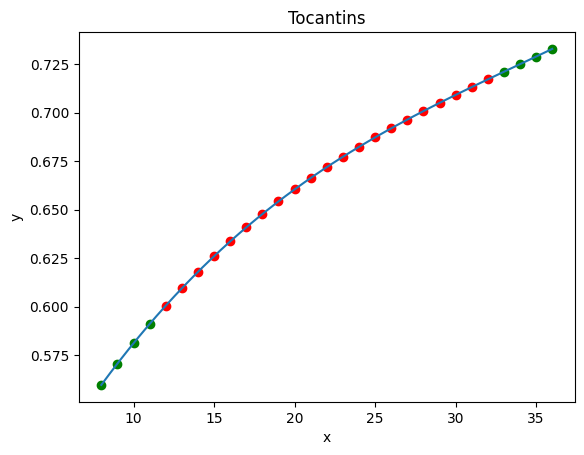

,Acre,Alagoas,Amazonas,Amapá,Bahia,Ceará,Distrito Federal,Espírito Santo,Goiás,Maranhão,...,Paraná,Rio de Janeiro,Rio Grande do Norte,Rondônia,Roraima,Rio Grande do Sul,Santa Catarina,Sergipe,São Paulo,Tocantins
Ano,,,,,,,,,,,,,,,,,,,,,
1980,0.530109,0.429782,0.623455,0.614455,0.519636,0.463800,0.768000,0.682582,0.679164,0.420764,...,0.718545,0.748145,0.473364,0.607364,0.694145,0.756982,0.749764,0.496164,0.746236,0.494364
1981,0.534931,0.433738,0.626545,0.620945,0.520564,0.468560,0.771400,0.684498,0.682996,0.423916,...,0.722255,0.751175,0.479236,0.609836,0.697175,0.759578,0.752916,0.499996,0.749884,0.500236
1982,0.539299,0.437322,0.629345,0.626825,0.521404,0.472872,0.774480,0.686234,0.686468,0.426772,...,0.725615,0.753919,0.484556,0.612076,0.699919,0.761930,0.755772,0.503468,0.753188,0.505556
1983,0.543122,0.440459,0.631796,0.631972,0.522139,0.476646,0.777176,0.687754,0.689507,0.429272,...,0.728556,0.756320,0.489213,0.614037,0.702320,0.763989,0.758272,0.506507,0.756080,0.510213
1984,0.553375,0.454328,0.635765,0.636814,0.533069,0.491186,0.780286,0.692632,0.692955,0.444163,...,0.731385,0.756630,0.503110,0.618571,0.704366,0.763943,0.760500,0.518159,0.759626,0.523636
1985,0.560319,0.462654,0.638972,0.641846,0.538702,0.500224,0.783195,0.695779,0.696198,0.452679,...,0.734275,0.758026,0.512232,0.621859,0.706580,0.765002,0.762871,0.525355,0.762835,0.532495
1986,0.567452,0.471383,0.642187,0.646724,0.544771,0.509670,0.786049,0.699039,0.699373,0.461701,...,0.737078,0.759262,0.521640,0.625248,0.708699,0.765916,0.765159,0.532853,0.765991,0.541605
1987,0.574741,0.480462,0.645405,0.651448,0.551226,0.519470,0.788844,0.702397,0.702479,0.471167,...,0.739793,0.760351,0.531291,0.628723,0.710726,0.766696,0.767366,0.540611,0.769089,0.550924
1988,0.582152,0.489837,0.648618,0.656016,0.558019,0.529567,0.791579,0.705837,0.705513,0.481013,...,0.742423,0.761307,0.541139,0.632272,0.712660,0.767356,0.769495,0.548585,0.772129,0.560407


In [55]:
df = read_csv_replace_missing_by_polynomial_2('idh_para_interpolacao.csv')
df = df.set_index('Ano')
df

In [56]:
df_2014 = df[df.index >= 2014]
df_2014

,Acre,Alagoas,Amazonas,Amapá,Bahia,Ceará,Distrito Federal,Espírito Santo,Goiás,Maranhão,...,Paraná,Rio de Janeiro,Rio Grande do Norte,Rondônia,Roraima,Rio Grande do Sul,Santa Catarina,Sergipe,São Paulo,Tocantins
Ano,,,,,,,,,,,,,,,,,,,,,
2014,0.711115,0.664799,0.708325,0.716623,0.692427,0.714492,0.832253,0.773701,0.753127,0.664236,...,0.785311,0.782693,0.717435,0.707289,0.735427,0.783285,0.805257,0.690442,0.821077,0.724805
2015,0.720255,0.677623,0.713064,0.720245,0.702212,0.728548,0.834900,0.778964,0.756319,0.677816,...,0.788311,0.784756,0.729953,0.714440,0.736260,0.785070,0.807829,0.700339,0.824371,0.735765
2016,0.720460,0.678679,0.713252,0.719540,0.702322,0.729780,0.834709,0.779234,0.756439,0.678618,...,0.788521,0.784734,0.729676,0.715208,0.735193,0.784895,0.807723,0.700643,0.824495,0.736289
2017,0.720230,0.678559,0.713457,0.718317,0.702079,0.730487,0.833592,0.779255,0.755752,0.678492,...,0.787750,0.784346,0.729464,0.715227,0.733665,0.784522,0.807152,0.700974,0.823540,0.736497
2018,0.720978,0.678519,0.712134,0.717073,0.701359,0.730532,0.832828,0.779188,0.754911,0.677901,...,0.786909,0.783741,0.729597,0.714702,0.732543,0.783751,0.806257,0.701153,0.822862,0.736179
2019,0.719885,0.677567,0.711601,0.714898,0.700573,0.729762,0.831721,0.778386,0.753449,0.677164,...,0.785264,0.781808,0.728743,0.713311,0.730047,0.782547,0.805098,0.700349,0.821577,0.735013
2020,0.718147,0.676709,0.710292,0.712888,0.698989,0.728468,0.829241,0.777058,0.751580,0.675634,...,0.783289,0.779336,0.727537,0.711794,0.728324,0.780869,0.803198,0.699926,0.819448,0.733560
2021,0.715615,0.675137,0.708773,0.711878,0.696715,0.726056,0.829263,0.775700,0.750997,0.673510,...,0.782951,0.778821,0.725495,0.709320,0.727354,0.780948,0.803216,0.697919,0.819125,0.731611
2022,0.716125,0.674331,0.709571,0.714049,0.697235,0.725333,0.830651,0.776127,0.752269,0.673283,...,0.784219,0.780350,0.725268,0.710168,0.729932,0.781852,0.804236,0.697548,0.820318,0.731667


In [57]:
for column in df_2014.columns:
    state = column
    file_name = f"2014_01_idh_{state}.csv"
    column_df = df_2014[[column]]
    column_df.to_csv(file_name, index=True)